# Import libraries

In [1]:
import pandas as pd
import numpy as np
import xgboost
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, learning_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm import tqdm
%matplotlib inline

# Import files

In [2]:
# import the train and test data as data
train_df = pd.read_csv('/kaggle/input/sce-ml-2023-course/train_2022.csv')
test_df = pd.read_csv('/kaggle/input/sce-ml-2023-course/test_2022.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,F,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,T,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,T,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,T,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,F,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# EDA

## Numeric data distributions

### Plot distributions

Descriptive statistics of the variables, graphs, and charts.
Presentation of data distributions was done using the seaborn and matplotlib libraries.
Numerical distributions of age and transportation fees.

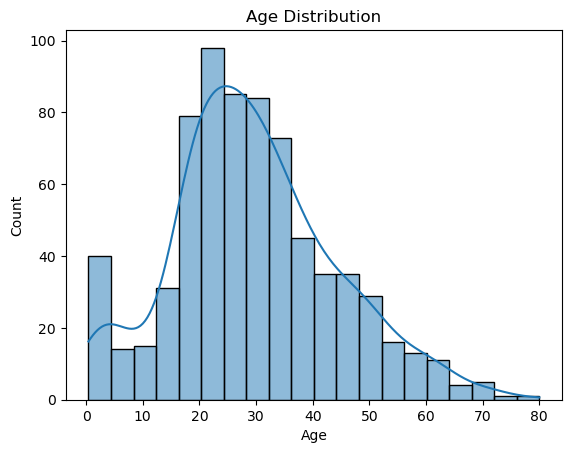

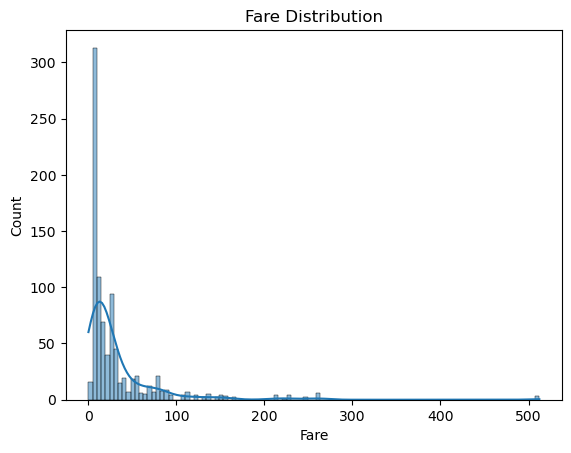

In [3]:
for col in ['Age', 'Fare']:
    sns.histplot(data=train_df.dropna(subset=[col]), x=col, kde=True)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title(col+' Distribution')
    plt.show()

## Numeric vs categorical data distributions

### Plot the Age/Fare distribution by class

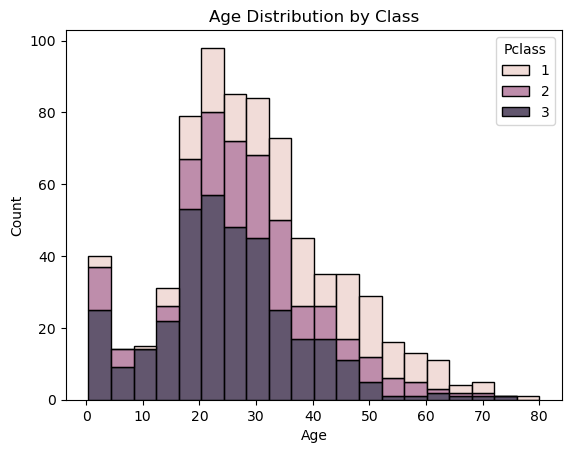

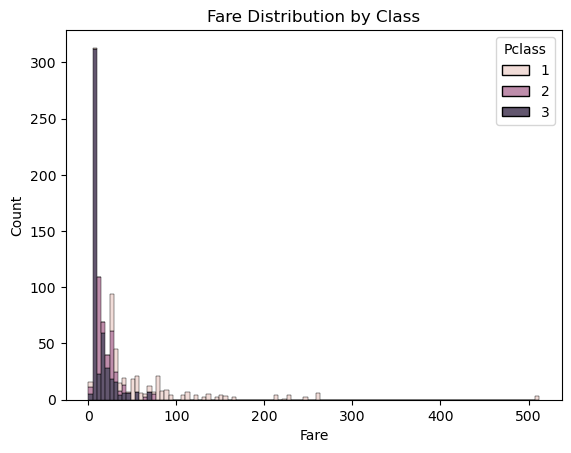

In [4]:
for col in ['Age', 'Fare']:
    sns.histplot(data=train_df.dropna(subset=[col]), x=col, hue='Pclass', multiple='stack')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title(col+' Distribution by Class')
    plt.show()

### Age distribution by sex

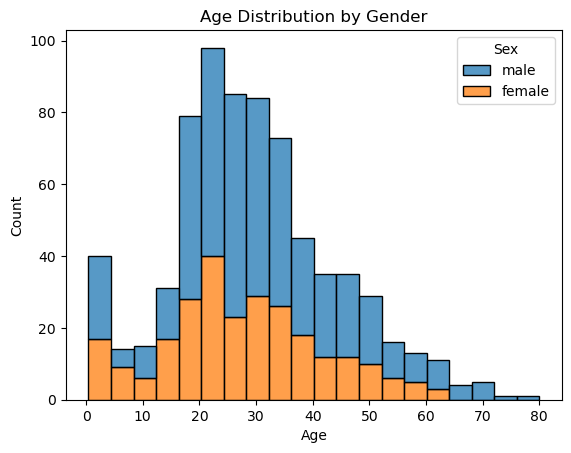

In [5]:
    sns.histplot(data=train_df.dropna(subset=[col]), x='Age', hue='Sex', multiple='stack')
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.title('Age Distribution by Gender')
    plt.show()

## Categorical features

### Plot Class, Sex and Embarked categorical features count

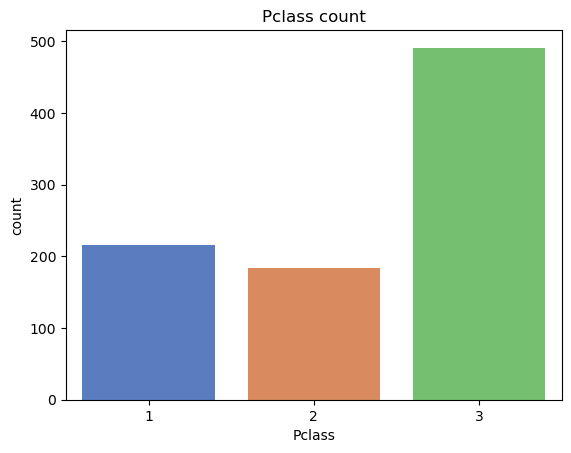

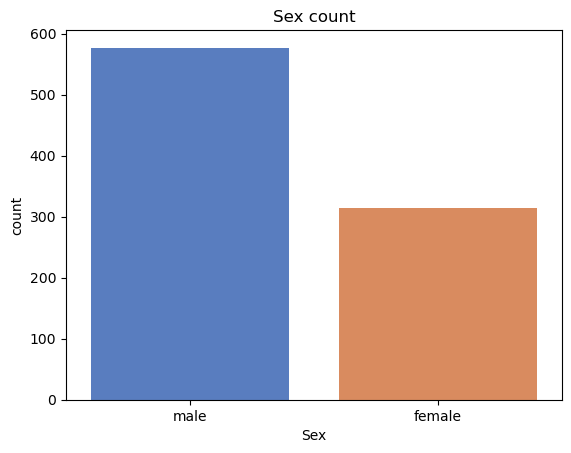

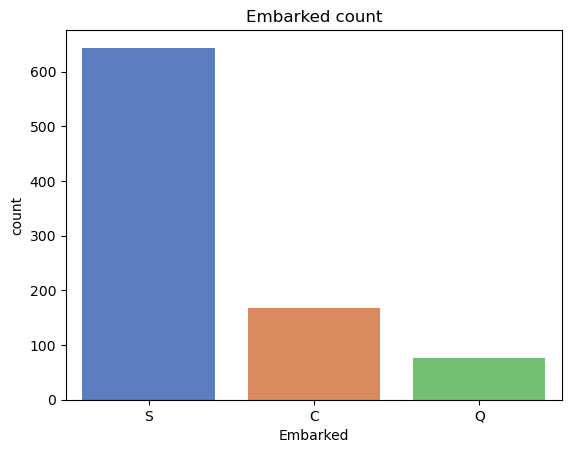

In [6]:
for col in ['Pclass', 'Sex', 'Embarked']:
    sns.countplot(data=train_df.dropna(subset=[col]), x = col,palette='muted')
    plt.title(col+' count')
    plt.show()

From the graphs, it can be seen that the number of men on the ship was higher than the number of women. Most of the people who boarded the ship were from class 3, and most of the people who boarded did so in "Southampton"

## The following part explores the correlation between survival and otherfeatures. The graph provides insights on the survival rates  across different passenger classes, aiding our understanding.

### Survived by passanger class

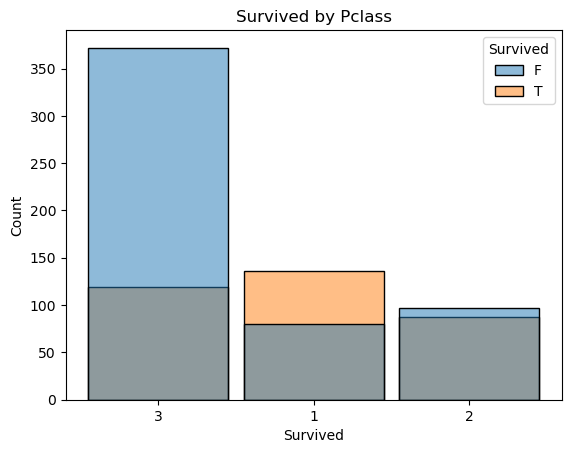

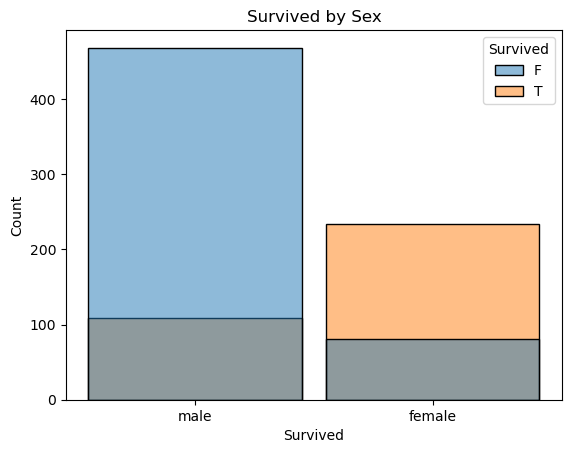

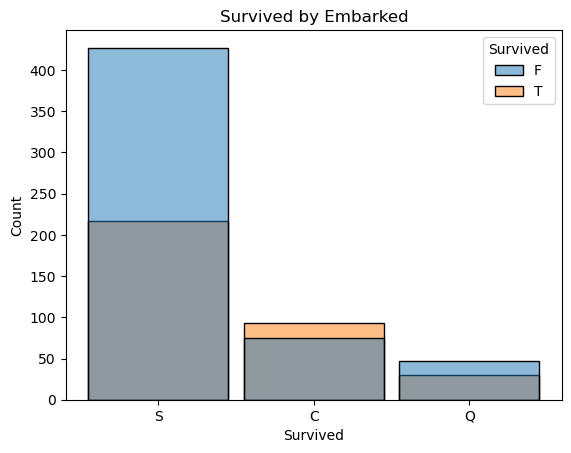

In [7]:
train_df['Pclass'] = train_df['Pclass'].astype(str)
for col in ['Pclass', 'Sex', 'Embarked']:
    sns.histplot(data=train_df, x=col, hue='Survived',shrink=0.9)
    plt.xlabel('Survived')
    plt.ylabel('Count')
    plt.title('Survived by '+col)
    plt.show()
train_df['Pclass'] = train_df['Pclass'].astype(int)

* It can be seen that the survival rate in class 3 is the lowest
* the survival rate among men is the lowest

#### Create new df that determine wheter you have siblings/spouse and perents/children
We will examine whether traveling with spouses and family members affected the passengers' survival. The hypothesis is that when people are with their family and spouses, there is a higher chance that they will help each other survive.

In [8]:
plot_df = pd.DataFrame(train_df['Survived'])
for col in ['SibSp', 'Parch']:
    plot_df[col] = train_df.apply(lambda x: 1 if (x[col]>0) else 0, axis=1)

#### Plot the results

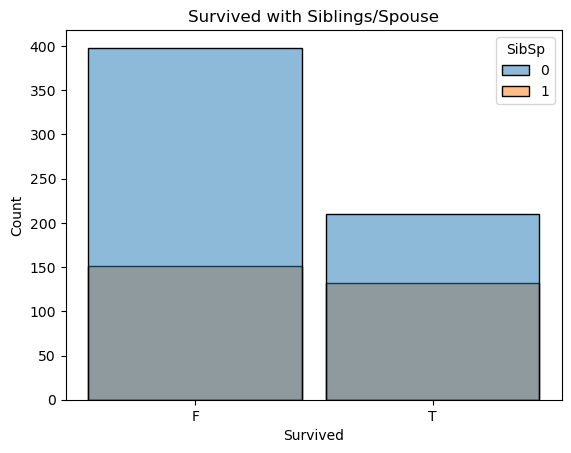

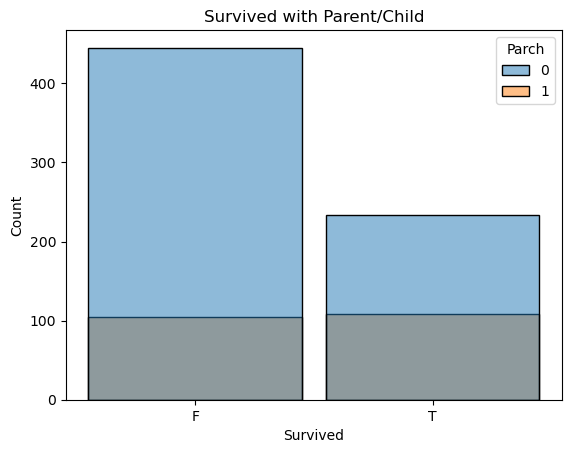

In [9]:
for col in [['SibSp', 'Siblings/Spouse'], ['Parch', 'Parent/Child']]:
    sns.histplot(data=plot_df, x='Survived', hue=col[0],shrink=0.9)
    plt.xlabel('Survived')
    plt.ylabel('Count')
    plt.title('Survived with '+col[1])
    plt.show()

It can be seen that the survival rate of those who traveled with someone is higher than that of those who traveled alone

## Conclutions

### 1. The 3rd class survival rate is much lower than the other classes.
### 2. Men's survival rate is much lower than women's.
### 3. The survival rate is much higher if the passenger traveled with Siblings/Spouse or/and Parent/Child.
### 4. There were more men than women on the ship.
### 5. There were more 3rd class passengers on the ship than any other class.
### 6. Most of the passengers embarked in 'Southhampton'

# Preprocess

## Look on the data first

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    object 
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 83.7+ KB


### it seems that we have 6 objects which means the machine learning algorithms can't read and we must process them somehow

Have a closer look where we have object and what we have to process

In [11]:
for temp_df in [[train_df,'Train Dataframe'], [test_df, 'Test Dataframe']]:
    print("\033[1m\033[4m"+'\n'+temp_df[1]+':'+"\033[0m")
    for column, dtype in temp_df[0].dtypes.items():
        if dtype == 'object':
            print(f"{column}: {dtype}")


Train Dataframe:
Survived: object
Name: object
Sex: object
Ticket: object
Cabin: object
Embarked: object

Test Dataframe:
Name: object
Sex: object
Ticket: object
Cabin: object
Embarked: object


## Check for a missing values

In [12]:
for temp_df in [[train_df,'Train Dataframe'], [test_df, 'Test Dataframe']]:
    print("\033[1m\033[4m"+temp_df[1]+' missing value:'+"\033[0m")
    null_counts = temp_df[0].isnull().sum()
    for column, count in null_counts.items():
        if count > 0:
            print(f"{column}: {count}")
    print('\n')

Train Dataframe missing value:
Age: 177
Cabin: 687
Embarked: 2


Test Dataframe missing value:
Age: 86
Fare: 1
Cabin: 327




## Turn 'Survived' from (T or F) into (1 or 0)

In [13]:
train_df['Survived'] = train_df['Survived'].map( {'T': 1, 'F': 0} ).astype(int)

## Age

### Check the corr before replacing nulls

In [14]:
# Extract the correlation between two features
corr_before = train_df.corr().loc['Age', 'Survived']

# Print the correlation value
print(f"Correlation between Cabin and Survived: {corr_before}")

Correlation between Cabin and Survived: -0.07722109457217756


/tmp/ipykernel_20/1338822406.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_before = train_df.corr().loc['Age', 'Survived']


#### replacing missing values in the 'Age' column of the train df based on the average age of survivors and non-survivors. It creates boolean conditions to identify specific subsets of data, calculates the mean age for each subset, and then uses the fillna() method to replace the missing values with the corresponding mean age values.

In [15]:
# Train dataframe 'Age' column missing values replacemrnt
train_df_bu = train_df.copy(deep = True)
ct_notna = ((train_df_bu['Age'].notna()) & (train_df_bu['Survived'] == 1))
ct_isna = ((train_df_bu['Age'].isna()) & (train_df_bu['Survived'] == 1))
ft_notna = ((train_df_bu['Age'].notna()) & (train_df_bu['Survived'] == 0))
ft_isna = ((train_df_bu['Age'].isna()) & (train_df_bu['Survived'] == 0))
train_df.loc[ct_isna,'Age'] = train_df.loc[ct_isna,'Age'].fillna(train_df.loc[ct_notna,'Age'].mean())
train_df.loc[ft_isna,'Age'] = train_df.loc[ft_isna,'Age'].fillna(train_df.loc[ft_notna,'Age'].mean())

## replace nulls in test df with KNNImputer method

In [16]:
# KNNImputer
# Separate the Age column into a separate array
s = test_df['Age'].values.reshape(-1, 1)
# Create a KNNImputer object and fit it to the data
imputer = KNNImputer(n_neighbors=5)
imputer.fit(s)

# Impute the missing values
X_imputed = imputer.transform(s)

# Replace the original missing values with the imputed values in the DataFrame
temp_df[0].loc[:, 'Age'] = X_imputed
print('Nulls in test df:\n',test_df.isnull().sum(),'\n')

Nulls in test df:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64 



## Corr 'increased'

In [17]:
# Extract the correlation between two features
corr_after = train_df.corr().loc['Age', 'Survived']

# Print the correlation value
print(f"Correlation between Cabin and Survived: {corr_after}")

Correlation between Cabin and Survived: -0.08536387241649765


/tmp/ipykernel_20/1799525425.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_after = train_df.corr().loc['Age', 'Survived']


## Check for nulls in 'Age'

In [18]:
for temp_df in [[train_df,'Train df'], [test_df,'Test df']]:
    print('\nThere are ',temp_df[0].isnull().sum().tolist()[4],'nulls in '+temp_df[1])


There are  0 nulls in Train df

There are  0 nulls in Test df


In [19]:
for temp_df in [[train_df,'Train Dataframe'], [test_df, 'Test Dataframe']]:
    print("\033[1m\033[4m"+temp_df[1]+' missing value:'+"\033[0m")
    null_counts = temp_df[0].isnull().sum()
    for column, count in null_counts.items():
        if count > 0:
            print(f"{column}: {count}")
    print('\n')

Train Dataframe missing value:
Cabin: 687
Embarked: 2


Test Dataframe missing value:
Fare: 1
Cabin: 327




## Fare

### Check where is null

In [20]:
print(f'The null is in Pclass ', test_df[test_df['Fare'].isnull()]['Pclass'].tolist()[0])

The null is in Pclass  3


### Find the mean of the 3rd class

In [21]:
print('The mean fare in Pclass 3 is:',test_df[test_df['Pclass'] == 3]['Fare'].mean())

The mean fare in Pclass 3 is: 12.459677880184334


### fill the null value that were missing from 'Fare' with the mean

In [22]:
test_df['Fare'] = test_df['Fare'].fillna(test_df[test_df['Pclass'] == 3]['Fare'].mean())

### Check if there are nulls

In [23]:
print('There are',test_df['Fare'].isnull().sum(),'fare nulls in test df')

There are 0 fare nulls in test df


## Embarked

### Fill nulls in 'Embarked' column

In [24]:
# check what rows have null in Embarked column

# create a Boolean mask for the column
mask = train_df['Embarked'].isnull()

# use the mask to filter the DataFrame using boolean indexing
null_rows = train_df[mask]
null_rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


## The missing Embarks are Pclass 1 so will find the most common embaking in pclass 1

In [25]:
# the missing Embarks are Pclass 1 so will find the most common emba
train_df['unique'] = train_df['Pclass'].astype(str)+train_df['Embarked']
temp_df = train_df[train_df['Pclass'] == 1]
most_common = temp_df['unique'].value_counts().idxmax().replace('1', '')
print('The most common embarkeing in Pcalss 1 is: ',most_common)

The most common embarkeing in Pcalss 1 is:  S


## fill the null value that were missing from 'Embarked' with the most common elemnt

In [26]:
train_df['Embarked'] = train_df['Embarked'].fillna(most_common)
train_df.drop(['unique'], axis=1, inplace=True)

## Check where we have more nulls

In [27]:
for temp_df in [[train_df,'Train Dataframe'], [test_df, 'Test Dataframe']]:
    print("\033[1m\033[4m"+temp_df[1]+' missing value:'+"\033[0m")
    null_counts = temp_df[0].isnull().sum()
    for column, count in null_counts.items():
        if count > 0:
            print(f"{column}: {count}")
    print('\n')

Train Dataframe missing value:
Cabin: 687


Test Dataframe missing value:
Cabin: 327




## Cabins

## Fill the null with 'N' for No cabin

In [28]:
for temp_df in [train_df, test_df]:
    temp_df['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'N' for i in temp_df['Cabin']])

In [29]:
for temp_df in [train_df, test_df]:
    print(temp_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pcl

## No null were found!

# Feature engineering

## Classify age group 0-1	infants, 1-12	Children, 13-17	Teenagers, 18-65	Adults, >65	Older adults

### Define function for classification

In [30]:
def categorize_age(age):
    if age < 1:
        return  'infants' #"infants"
    elif age >= 1 and age <= 12:
        return 'Children' #"Children"
    elif age >= 13 and age <= 17:
        return 'Teenagers' #"Teenagers"
    elif age >= 18 and age <= 65:
        return 'Adults' #"Adults"
    elif age > 65:
        return 'Older adults' #"Older adults"

### Create 'age_group' column

In [31]:
for temp_df in [train_df,test_df]:
    temp_df['age_group'] = temp_df['Age'].apply(lambda x: categorize_age(x))
    print(temp_df['age_group'].unique())

['Adults' 'Children' 'Teenagers' 'Older adults' 'infants']
['Adults' 'Teenagers' 'Children' 'Older adults' 'infants']


### Survival percentage of age group

In [32]:
# Filter the DataFrame to include only rows where 'Survived' is True
filtered_df = train_df[train_df['Survived'] == 1]

# Group the filtered data by 'sex+age_group' and calculate the count of survivors and total count in each group
group_counts = train_df.groupby('age_group')['Survived'].count()
survived_counts = filtered_df.groupby('age_group')['Survived'].count()

# Calculate the percentage of survivors out of the group
percentage_survived = (survived_counts / group_counts) * 100

# Sort the data in descending order
percentage_survived = percentage_survived.sort_values(ascending=False)

# Display the result
print(percentage_survived)

age_group
infants         100.000000
Children         53.225806
Teenagers        47.727273
Adults           36.363636
Older adults     12.500000
Name: Survived, dtype: float64


### seem like there more younger your group age the more change you have to survive

## combine group age and sex

In [33]:
for temp_df in [train_df,test_df]:
    temp_df['sex+age_group'] = temp_df['Sex']+temp_df['age_group']

In [34]:
# Filter the DataFrame to include only rows where 'Survived' is True
filtered_df = train_df[train_df['Survived'] == 1]

# Group the filtered data by 'sex+age_group' and calculate the count of survivors and total count in each group
group_counts = train_df.groupby('sex+age_group')['Survived'].count()
survived_counts = filtered_df.groupby('sex+age_group')['Survived'].count()

# Calculate the percentage of survivors out of the group
percentage_survived = (survived_counts / group_counts) * 100

# Sort the data in descending order
percentage_survived = percentage_survived.sort_values(ascending=False)

# Display the result
print(percentage_survived)

sex+age_group
femaleinfants       100.000000
maleinfants         100.000000
femaleTeenagers      82.608696
femaleAdults         75.289575
femaleChildren       56.666667
maleChildren         50.000000
maleAdults           16.634051
maleOlder adults     12.500000
maleTeenagers         9.523810
Name: Survived, dtype: float64


### it seems like if you are more younger and female you will have more chance to survive

### Create dictionary for sex+age_group

will map them as like their chance to survive and will power it by 2 to make the diffrence more significant

In [35]:
age_group_dic = {
    'infants': 100**2,
    'Children': 54**2,
    'Teenagers': 48**2,
    'Adults': 37**2,
    'Older adults': 13**2
}
sex_age_group_dic = {
    'femaleinfants': 100**2,
    'maleinfants': 100**2,
    'femaleTeenagers': 83**2,
    'femaleAdults': 75**2,
    'femaleChildren': 57**2,
    'maleChildren': 50**2,
    'maleAdults': 17**2,
    'maleOlder adults': 13**2,
    'femaleOlder adults': 13**2,
    'maleTeenagers': 10**2
}
for temp_df in [train_df, test_df]:
    temp_df['sex+age_group'] = temp_df['sex+age_group'].map(sex_age_group_dic)
    temp_df['age_group'] = temp_df['age_group'].map(age_group_dic)

### Check for nulls

In [36]:
test_df['sex+age_group'].isnull().sum()

0

## Family size/ Alone travel

#### SibSp

In [37]:
train_df['Survived'].groupby(train_df['SibSp']).mean()

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64

#### seems like if you have SibSp [1,2] you have more chance to survive

#### Parch

In [38]:
train_df['Survived'].groupby(train_df['Parch']).mean()

Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: Survived, dtype: float64

#### seems like if you have parch [1,3] you have more chance to survive

In [39]:
for temp_df in [train_df,test_df]:
    temp_df["family"] = temp_df["SibSp"]+temp_df["Parch"]+1

In [40]:
for temp_df in [train_df,test_df]:
    temp_df["Alone"] = temp_df["family"].apply(lambda x: 1 if x == 1 else 0)
    temp_df["small_family"] = temp_df["family"].apply(lambda x: 1 if (2 <= x and x < 5) else 0)
    temp_df["middle_family"] = temp_df["family"].apply(lambda x: 1 if (5 <= x < 8) else 0)
    temp_df["big_family"] = temp_df["family"].apply(lambda x: 1 if (8 <= x) else 0)  

## Extract titles

In [41]:
# get the passenger's title from the 'Name' column
def getTitle(name):
    return name.split(',')[1].split('.')[0].strip()

for temp_df in [train_df, test_df]:
# create a 'title' column to show personal title of each passenger
    temp_df['title'] = temp_df.apply(lambda x: getTitle(x['Name']), axis=1)



### map titles

In [42]:
unique_titles = set(test_df['title'].unique().tolist()+train_df['title'].unique().tolist())
unique_titles_list = list(unique_titles)

# check what title there are
# print(unique_titles_list)

title_dict = {
    'Major': 3,
    'Col': 3,
    'Capt': 3,
    'Dr': 3,
    'Rev': 3,
    'Mr': 2,
    'Miss': 1,
    'Mlle': 1,
    'Mme': 1,
    'Ms': 1,
    'Mrs': 1,
    'Master': 0,
    'Jonkheer': 3,
    'Don': 3,
    'Sir': 3,
    'the Countess': 3,
    'Dona': 3,
    'Lady': 3,
}
for temp_df in [train_df, test_df]:
    temp_df['title'] = temp_df['title'].map(title_dict)

In [43]:
train_df['Survived'].groupby(train_df['title']).mean().sort_values(ascending=False)

title
1    0.739550
0    0.575000
3    0.347826
2    0.156673
Name: Survived, dtype: float64

#### seems like there are diffrent survival rates for the diffrent title and it can help the model to classify

### Check corr between title and survival

In [44]:
# Extract the correlation between two features
correlation = train_df.corr().loc['title', 'Survived']

# Print the correlation value
print(f"Correlation between title and Survived: {correlation}")

Correlation between title and Survived: -0.4721284684776633


/tmp/ipykernel_20/1376447027.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = train_df.corr().loc['title', 'Survived']


#### there are negative corr between title and survived

## Ticket

#### Seperate between the number and the letters of the ticket

In [45]:
for temp_df in [train_df, test_df]:
    temp_df["Ticket"] = [i.replace(".", "").replace("/", "").strip().split(' ')[0] if not i.isdigit() else "N" for i in list(temp_df.Ticket)]

In [46]:
train_df['Survived'].groupby(train_df['Ticket']).mean().sort_values(ascending=False)

Ticket
SC         1.000000
SWPP       1.000000
FCC        0.800000
SCAH       0.666667
PP         0.666667
PC         0.650000
SCParis    0.500000
STONO2     0.500000
PPP        0.500000
SCPARIS    0.428571
STONO      0.416667
C          0.400000
N          0.384266
CA         0.341463
WEP        0.333333
LINE       0.250000
SOC        0.166667
SOTONOQ    0.133333
WC         0.100000
A5         0.095238
SOTONO2    0.000000
SP         0.000000
A4         0.000000
SOPP       0.000000
SOP        0.000000
SCOW       0.000000
Fa         0.000000
FC         0.000000
CASOTON    0.000000
AS         0.000000
SCA4       0.000000
Name: Survived, dtype: float64

#### It seems like diffrent tickets may imply for the survival rate, might be because the ticket were for cabins that were near the saving boats

## Check unique tickets in both dfs

In [47]:
set(train_df['Ticket'].astype(str)).intersection(set(test_df['Ticket'].astype(str)))

{'A4',
 'A5',
 'C',
 'CA',
 'FC',
 'FCC',
 'N',
 'PC',
 'PP',
 'SC',
 'SCA4',
 'SCAH',
 'SCPARIS',
 'SCParis',
 'SOC',
 'SOPP',
 'SOTONO2',
 'SOTONOQ',
 'STONO',
 'STONO2',
 'WC',
 'WEP'}

### One-Hot encode for Tickets

In [48]:
train_df = pd.get_dummies(train_df, columns = ["Ticket"], dtype=int)
test_df = pd.get_dummies(test_df, columns = ["Ticket"], dtype=int)

## maping categorical feature 'Sex' into numerical

In [49]:
for temp_df in [train_df,test_df]:
    temp_df['Sex'] = temp_df['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

# Encode

## perform One-Hot encode to 'Embarked' colum

In [50]:
train_df = pd.get_dummies(train_df, columns=['Embarked'], dtype=int)
test_df = pd.get_dummies(test_df, columns=['Embarked'], dtype=int)

# Prepair train and test data

#### copy the dfs and define the columns that will be in use

In [51]:
# preparing training data
train_df_copy = train_df.copy(deep=True)
test_df_copy = test_df.copy(deep = True)
columns = ['Pclass', 'Age', 'Fare','Sex', 'Embarked_C', 'Embarked_Q',
           'Embarked_S', 'family', 'Alone', 'title', 'Ticket_A4',
           'Ticket_A5', 'Ticket_C', 'Ticket_CA', 'Ticket_FC', 'Ticket_FCC',
           'Ticket_PC', 'Ticket_PP', 'Ticket_SC', 'Ticket_SCA4', 'Ticket_SCAH',
           'Ticket_SCPARIS', 'Ticket_SCParis', 'Ticket_SOC', 'Ticket_SOPP', 'Ticket_SOTONO2',
           'Ticket_SOTONOQ', 'Ticket_STONO', 'Ticket_STONO2', 'Ticket_WC', 'Ticket_WEP','sex+age_group','Survived'
]
train_df_copy = train_df_copy[columns]
test_df_copy = test_df_copy[columns[:-1]]
sc = StandardScaler()
for temp_df in [train_df_copy, test_df_copy]:
    temp_df = sc.fit_transform(temp_df)

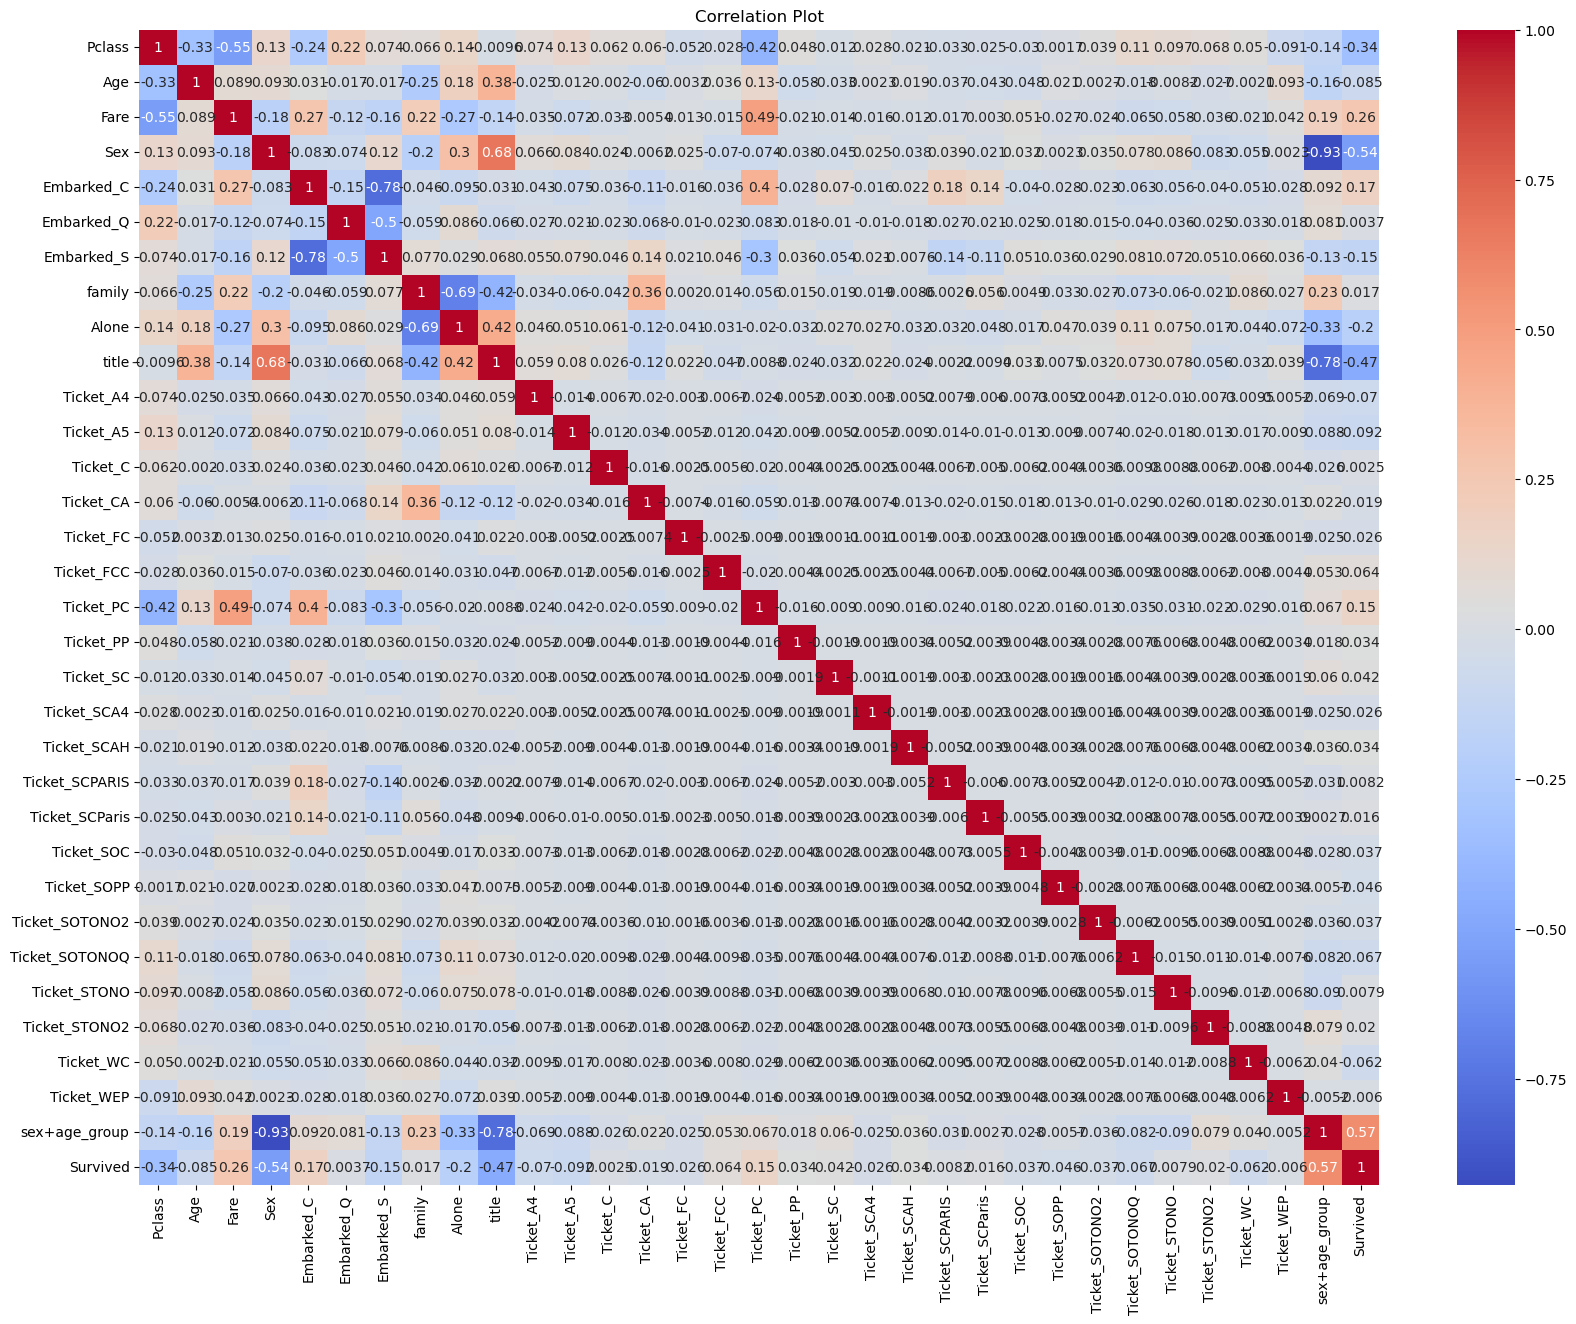

In [52]:
# Calculate the correlation matrix
corr_matrix = train_df_copy.corr()

# Create a correlation plot
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Plot')
plt.show()

# Data splitting

In [53]:
X = train_df_copy.drop('Survived', axis=1)
y = train_df_copy['Survived']

# Define the ML model

## Use GridSearchCV to find good hyperparameters

In [54]:
# rfc = RandomForestClassifier(random_state=0)
# param_grid = { 
#     'n_estimators': [100,200,250,300],
#     'max_features': ['auto', 'sqrt'],
#     'max_depth' : [6,7,8,9],
#     'criterion' :['gini', 'entropy']
# }
# grid = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5, n_jobs=-1)
# grid.fit(X,y)
# grid.best_params_

The best hyperparamets from the GridSearch are:
criterion='gini', max_depth=8, max_features='auto', n_estimators=100,random_state=0

## Create Random Forest Classifier and train the data

In [55]:
# Create a Random Forest Classifier object
rfc = RandomForestClassifier(criterion='gini', max_depth=8, max_features='auto', n_estimators=100,random_state=0)

# Train the classifier on the training data
rfc.fit(X, y)

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(max_depth=8, max_features='auto', random_state=0)

## Test the model with cross validation method

In [56]:
# Create the K-Fold cross-validation object
kfold = KFold(n_splits=5)

# Perform cross-validation and get the scores
scores = cross_val_score(rfc, X, y, cv=kfold)

# Print the accuracy for each fold
for i, score in enumerate(scores):
    print(f"Fold {i+1} Accuracy: {score}")

# Print the mean accuracy and standard deviation across all folds
print(f"Mean Accuracy: {scores.mean()}")
print(f"Standard Deviation: {scores.std()}")

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Fold 1 Accuracy: 0.8715083798882681
Fold 2 Accuracy: 0.8539325842696629
Fold 3 Accuracy: 0.8426966292134831
Fold 4 Accuracy: 0.8089887640449438
Fold 5 Accuracy: 0.8764044943820225
Mean Accuracy: 0.8507061703596761
Standard Deviation: 0.024116551430702245


## Learning curve

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

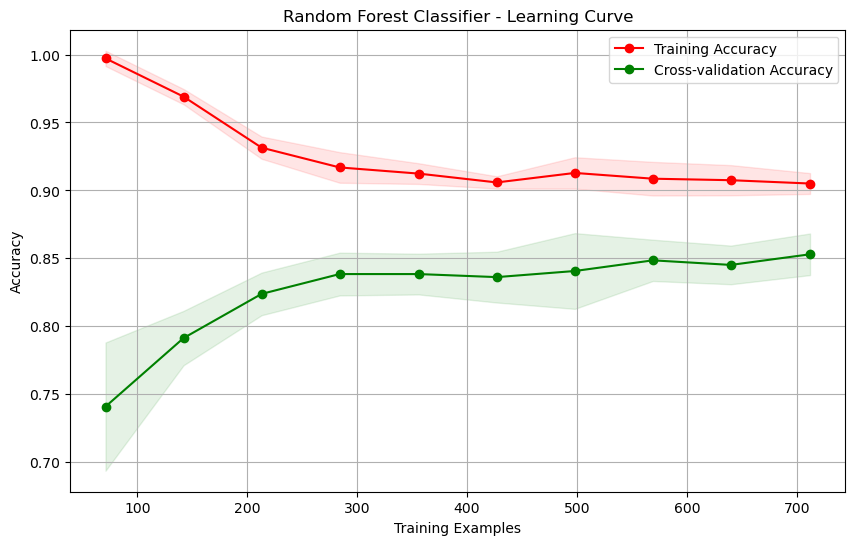

In [57]:
# Create the learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    rfc, X, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate the mean and standard deviation of train and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.title('Random Forest Classifier - Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.grid(True)
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='g')
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training Accuracy')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation Accuracy')
plt.legend(loc='best')
plt.show()

# Prepair submission data

In [58]:
# test_df_bu = test_df.copy(deep = True)
ID = test_df['PassengerId']
P = rfc.predict(test_df_copy)

# Prepair submission file

In [59]:
submission = pd.DataFrame( { 'PassengerId': ID , 'Survived': P } )
submission['Survived'] = submission['Survived'].replace({1: 'T', 0: 'F'})
submission.to_csv('submission.csv' , index = False )
